<a href="https://colab.research.google.com/github/ruorong/classifcation/blob/main/classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import os
import time
import random
import datetime
import sklearn

In [2]:
tf.__version__

'2.6.0'

In [3]:
!git clone https://github.com/ruorong/classifcation.git

Cloning into 'classifcation'...
remote: Enumerating objects: 2557, done.
remote: Counting objects: 100% (2557/2557), done.
remote: Compressing objects: 100% (2555/2555), done.
remote: Total 2557 (delta 13), reused 2537 (delta 1), pack-reused 0
Receiving objects: 100% (2557/2557), 92.74 MiB | 28.69 MiB/s, done.
Resolving deltas: 100% (13/13), done.


# 数据增强

In [21]:
for dirs in glob.glob("/content/classifcation/Garbagepicture/*"):
  print(dirs)


/content/classifcation/Garbagepicture/paper
/content/classifcation/Garbagepicture/plastic
/content/classifcation/Garbagepicture/glass
/content/classifcation/Garbagepicture/cardboard
/content/classifcation/Garbagepicture/metal


In [22]:
for dirs in glob.glob("/content/classifcation/Garbagepicture/*"): 
  # print(dirs)
  paths = glob.glob(dirs + "/*")
  # print(paths)
print(paths)

['/content/classifcation/Garbagepicture/metal/metal90.jpg', '/content/classifcation/Garbagepicture/metal/metal409.jpg', '/content/classifcation/Garbagepicture/metal/metal220.jpg', '/content/classifcation/Garbagepicture/metal/metal111.jpg', '/content/classifcation/Garbagepicture/metal/metal362.jpg', '/content/classifcation/Garbagepicture/metal/metal18.jpg', '/content/classifcation/Garbagepicture/metal/metal25.jpg', '/content/classifcation/Garbagepicture/metal/metal75.jpg', '/content/classifcation/Garbagepicture/metal/metal202.jpg', '/content/classifcation/Garbagepicture/metal/metal373.jpg', '/content/classifcation/Garbagepicture/metal/metal294.jpg', '/content/classifcation/Garbagepicture/metal/metal351.jpg', '/content/classifcation/Garbagepicture/metal/metal115.jpg', '/content/classifcation/Garbagepicture/metal/metal149.jpg', '/content/classifcation/Garbagepicture/metal/metal280.jpg', '/content/classifcation/Garbagepicture/metal/metal274.jpg', '/content/classifcation/Garbagepicture/meta

In [23]:
print(time.time())

1634978383.0968573


In [25]:
for dirs in glob.glob("/content/classifcation/Garbagepicture/*"): 
  # print(dirs)
  paths = glob.glob(dirs + "/*")
  # print(paths)
  for path in paths:
    temp = os.path.dirname(path) + "/" + str(time.time()) + ".png"
    # temp = os.path.dirname(path)  # 去掉文件名，返回目录  
    print(temp)

/content/classifcation/Garbagepicture/paper/1634978394.3934102.png
/content/classifcation/Garbagepicture/paper/1634978394.3996847.png
/content/classifcation/Garbagepicture/paper/1634978394.400057.png
/content/classifcation/Garbagepicture/paper/1634978394.4001226.png
/content/classifcation/Garbagepicture/paper/1634978394.4001749.png
/content/classifcation/Garbagepicture/paper/1634978394.4002347.png
/content/classifcation/Garbagepicture/paper/1634978394.4002833.png
/content/classifcation/Garbagepicture/paper/1634978394.4003308.png
/content/classifcation/Garbagepicture/paper/1634978394.4003775.png
/content/classifcation/Garbagepicture/paper/1634978394.4004242.png
/content/classifcation/Garbagepicture/paper/1634978394.4004712.png
/content/classifcation/Garbagepicture/paper/1634978394.4005435.png
/content/classifcation/Garbagepicture/paper/1634978394.4013066.png
/content/classifcation/Garbagepicture/paper/1634978394.401388.png
/content/classifcation/Garbagepicture/paper/1634978394.401442.pn

In [8]:
# # start = datetime.datetime.now()
# for dirs in glob.glob("/content/classifcation/Garbage classification/*"): # glob返回list。返回classfication下目录
#   paths = glob.glob(dirs + "/*") # 以列表返回
  
#   for path in paths[:2]:
#     img = tf.keras.preprocessing.image.load_img(path)
#     img = np.array(img) # 转化为 ndarray的形式
#     img = tf.image.adjust_brightness(img,0.3) # 调整 RGB 或灰度图像的亮度
#     temp = os.path.dirname(path) + "/" + str(time.time()) + ".png"
#     # tf.keras.preprocessing.image.save_img(temp,img)

In [27]:
# # 数据增强，加强亮度
# start = datetime.datetime.now()
# for dirs in glob.glob("/content/classifcation/Garbagepicture/*"): # glob返回list。返回classfication下目录
#   paths = glob.glob(dirs + "/*") # 以列表返回
  
#   for path in paths:
#     img = tf.keras.preprocessing.image.load_img(path)
#     img = np.array(img) # 转化为 ndarray的形式
#     img = tf.image.adjust_brightness(img,0.3) # 调整 RGB 或灰度图像的亮度
#     temp = os.path.dirname(path) + "/" + str(time.time()) + ".png"
#     tf.keras.preprocessing.image.save_img(temp,img)
#   for path in paths:
#     img = tf.keras.preprocessing.image.load_img(path)
#     img = np.array(img) # 转化为 ndarray的形式
#     img = tf.image.flip_left_right(img) #水平翻转图像(从左到右)
#     temp = os.path.dirname(path) + "/" + str(time.time()) + ".png"
#     tf.keras.preprocessing.image.save_img(temp,img)
# end = datetime.datetime.now()
# print(end-start)

In [28]:
!pwd
# !mv /content/classifcation/ /content/yes
# !mv /content/old2/ /content/classifcation


/content


In [ ]:
# 数据增强，加强亮度
start = datetime.datetime.now()
for dirs in glob.glob("./pokemanpicture/*"): # glob返回list。返回classfication下目录
  paths = glob.glob(dirs + "/*") # 以一个列表形式返回
  
  for path in paths:
    img = tf.keras.preprocessing.image.load_img(path)
    img = np.array(img) # 转化为 ndarray的形式
    img = tf.image.adjust_brightness(img,0.3) # 调整 RGB 或灰度图像的亮度
    temp = os.path.dirname(path) + "/" + str(time.time()) + ".png"
    tf.keras.preprocessing.image.save_img(temp,img)
  for path in paths:
    img = tf.keras.preprocessing.image.load_img(path)
    img = np.array(img) # 转化为 ndarray的形式
    img = tf.image.flip_left_right(img) #水平翻转图像(从左到右)
    temp = os.path.dirname(path) + "/" + str(time.time()) + ".png"
    tf.keras.preprocessing.image.save_img(temp,img)
end = datetime.datetime.now()
print(end-start)

In [ ]:
# start = datetime.datetime.now()
# for dirs in glob.glob("./pokemanpicture/*"):
#   flag = 1
#   for path in glob.glob(dirs + "/*"):
#     img = tf.keras.preprocessing.image.load_img(path)
#     img = np.array(img) # 转化为 ndarray的形式
#     img = tf.image.adjust_brightness(img,0.3)
#     temp = os.path.dirname(path) + "/" + str(time.time()) + ".png"
#     tf.keras.preprocessing.image.save_img(temp,img)
#     if flag:
#       print(temp)
#       flag = 0
# end = datetime.datetime.now()
# print(end-start)

./pokemanpicture/mewtwo/1634297470.5968313.png


/home/long/.conda/envs/long/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


./pokemanpicture/charmander/1634297539.8135343.png
./pokemanpicture/squirtle/1634297615.9221616.png
./pokemanpicture/bulbasaur/1634297672.387268.png
./pokemanpicture/pikachu/1634297737.1577804.png
0:05:30.447628


# 划分数据集

In [31]:
# for dirs in glob.glob("/content/classifcation/Garbagepicture/*"):
#   name = dirs.split("/")
#   print(name)

['', 'content', 'classifcation', 'Garbagepicture', 'paper']
['', 'content', 'classifcation', 'Garbagepicture', 'plastic']
['', 'content', 'classifcation', 'Garbagepicture', 'glass']
['', 'content', 'classifcation', 'Garbagepicture', 'cardboard']
['', 'content', 'classifcation', 'Garbagepicture', 'metal']


In [37]:
# images = []
# labels = []
# name2label = dict()

# t = 0
# for dirs in glob.glob("/content/classifcation/Garbagepicture/*"):
#   name = dirs.split("/")[4]
#   name2label[name] = t
#   t += 1
#   for path in glob.glob(dirs + "/*"):
#     images.append(path)
# random.shuffle(images)
# for path in images:
#   name = path.split("/")[4]
#   print(name)  

流式输出内容被截断，只能显示最后 5000 行内容。
paper
paper
cardboard
metal
plastic
glass
plastic
glass
paper
metal
glass
paper
glass
metal
plastic
paper
paper
cardboard
plastic
paper
plastic
plastic
paper
paper
glass
paper
plastic
plastic
glass
cardboard
cardboard
plastic
cardboard
cardboard
paper
plastic
metal
cardboard
cardboard
cardboard
metal
glass
cardboard
glass
glass
glass
paper
cardboard
metal
paper
plastic
glass
plastic
paper
metal
cardboard
plastic
glass
plastic
plastic
paper
plastic
cardboard
cardboard
cardboard
metal
glass
plastic
plastic
plastic
paper
paper
cardboard
metal
paper
metal
paper
plastic
metal
paper
paper
glass
glass
glass
metal
glass
plastic
glass
glass
paper
cardboard
paper
metal
plastic
glass
paper
glass
plastic
glass
paper
plastic
cardboard
paper
paper
paper
plastic
metal
paper
cardboard
glass
glass
plastic
paper
metal
metal
glass
metal
paper
plastic
plastic
glass
paper
metal
plastic
paper
plastic
cardboard
paper
plastic
plastic
glass
metal
paper
plastic
paper
cardboard
paper
g

In [41]:
# images = []
# labels = []
# name2label = dict()

# t = 0
# for dirs in glob.glob("/content/classifcation/Garbagepicture/*"):
#   name = dirs.split("/")[4]
#   name2label[name] = t
#   t += 1
#   for path in glob.glob(dirs + "/*"):
#     images.append(path)
# random.shuffle(images)
# for path in images:
#   name = path.split("/")[4]
#   labels.append(name2label[name]) # 打乱后的标签值列表

# df = pd.DataFrame({"images":images,"labels":labels})
# df.to_csv("./image.csv",index=False)
# print(name2label)
# df.head()

{'paper': 0, 'plastic': 1, 'glass': 2, 'cardboard': 3, 'metal': 4}


,images,labels
0,/content/classifcation/Garbagepicture/metal/16...,4
1,/content/classifcation/Garbagepicture/glass/gl...,2
2,/content/classifcation/Garbagepicture/plastic/...,1
3,/content/classifcation/Garbagepicture/metal/me...,4
4,/content/classifcation/Garbagepicture/metal/me...,4


In [ ]:
images = [] # 存入图像的路径
labels = [] # 存入打乱后图像路径，对应的标签
name2label = dict()

t = 0
for dirs in glob.glob("./pokemanpicture/*"):
  name = dirs.split("/")[4]
  name2label[name] = t
  t += 1
  for path in glob.glob(dirs + "/*"):
    images.append(path) # 存入照片地址
random.shuffle(images) # 打乱图像路径

for iamge in images:
  name = iamge.split("/")[4]
  labels.append(name2label[name]) # 打乱后的标签值列表

df = pd.DataFrame({"images":images,"labels":labels})
df.to_csv("./image.csv",index=False)
print(name2label)
df.head()

{'mewtwo': 0, 'charmander': 1, 'squirtle': 2, 'bulbasaur': 3, 'pikachu': 4}


,images,labels
0,./pokemanpicture/mewtwo/1634297486.2058926.png,0
1,./pokemanpicture/squirtle/1634297617.1559815.png,2
2,./pokemanpicture/pikachu/00000129.jpg,4
3,./pokemanpicture/mewtwo/1634297521.554187.png,0
4,./pokemanpicture/pikachu/00000057.png,4


In [42]:
def load_data(model):
    df = pd.read_csv("./image.csv")
    images = df["images"]
    labels = df["labels"]
    if model == "train":
        print("训练集：" + str(len(labels[:int(0.7*len(labels))])))
        return images[:int(0.7*len(images))], labels[:int(0.7*len(labels))]
    elif model == "val":
        print("验证集：" + str(len(labels[int(0.7*len(labels)):])))
        return images[int(0.7*len(images)):], labels[int(0.7*len(labels)):]

# 数据预处理并放入tf.data中

In [43]:
!pwd

/content


In [46]:
# x = tf.io.read_file("/content/classifcation/Garbagepicture/cardboard/1634978542.5093517.png")
# x = tf.io.decode_jpeg(x,channels=3) #将JPEG编码的图像解码为uint8张量
# print(x.shape,x.dtype)
# x = tf.image.resize(x,(244,244))
# x = tf.cast(x,dtype=tf.float32) / 255.

(384, 512, 3) <dtype: 'uint8'>


In [ ]:
x = tf.io.read_file("./pokemanpicture/bulbasaur/00000000.png")
x = tf.io.decode_jpeg(x,channels=3) #将JPEG编码的图像解码为uint8张量
print(x.shape,x.dtype)
x = tf.image.resize(x,(244,244))
x = tf.cast(x,dtype=tf.float32) / 255.

(900, 900, 3) <dtype: 'uint8'>


In [47]:
def preprocess(x,y):
    x = tf.io.read_file(x)
    x = tf.io.decode_jpeg(x,channels=3)
    x = tf.image.resize(x,(224,224))
    x = tf.cast(x,dtype=tf.float32) / 255.
    
    y = tf.convert_to_tensor(y)
    y = tf.one_hot(y,depth=5)
    return x,y

In [49]:
batch_size = 8
train_data = tf.data.Dataset.from_tensor_slices(load_data("train")) #函数基于images和labels构建Dataset,函数会对tensor和numpy array的处理一视同仁
train_data = train_data.shuffle(1000).map(preprocess).batch(batch_size)

val_data = tf.data.Dataset.from_tensor_slices(load_data("val"))
val_data = val_data.map(preprocess).batch(batch_size)  # 不能shuffle 不然后面混淆矩阵找不到真是标签

print(train_data)
print(val_data)

训练集：5019
验证集：2151
<BatchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>


# 构建模型

In [51]:
base_model = tf.keras.applications.vgg16.VGG16(weights="/content/classifcation/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5",include_top=False)

for layer in base_model.layers[:-4]:
    layer.trainable = False
# base_model.summary()
  
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(256,activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(5,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 14,847,301
Trainable params: 7,212,037
Non-trainable params: 7,635,264
_________________________________________________________________


# 模型编译和训练

In [ ]:
easystop = tf.keras.callbacks.EarlyStopping(patience=3,min_delta=0.01)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
start = datetime.datetime.now()
history = model.fit(train_data,validation_data=val_data,callbacks=[easystop],epochs=200)
end = datetime.datetime.now()
print("*"*100)
print(end - start)

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


628/628 [==============================] - 147s 182ms/step - loss: 0.7230 - accuracy: 0.7201 - val_loss: 0.3980 - val_accuracy: 0.8563
Epoch 2/200
628/628 [==============================] - 110s 175ms/step - loss: 0.3145 - accuracy: 0.8894 - val_loss: 0.3284 - val_accuracy: 0.8773
Epoch 3/200
628/628 [==============================] - 110s 175ms/step - loss: 0.1601 - accuracy: 0.9460 - val_loss: 0.7048 - val_accuracy: 0.8043


# 绘制训练集和验证集上损失值、准确率

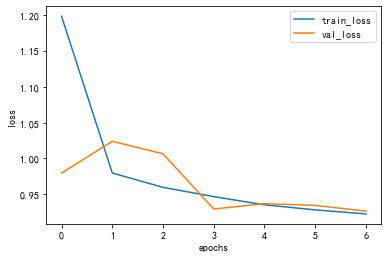

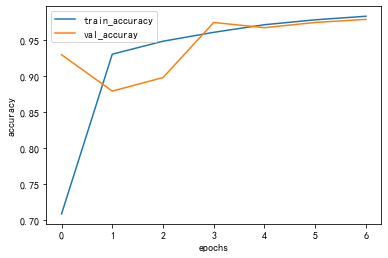

In [ ]:
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuray = history.history["val_accuracy"]

plt.plot(train_loss,label="train_loss")
plt.plot(val_loss,label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig("loss3.png")
plt.show()


plt.plot(train_accuracy,label="train_accuracy")
plt.plot(val_accuray,label="val_accuray")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig("accuracy3.png")
plt.show()

# 绘制验证集混淆矩阵

In [ ]:
y_pred = model.predict_generator(val_data)
y_pred_classes = np.argmax(y_pred,axis=1)
y_true = list(load_data("val")[1])
matrix = sklearn.metrics.confusion_matrix(load_data("val")[1],y_pred_classes)
print(matrix)

2021-10-15 21:27:54.385675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:27:58.138822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:27:59.928378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:28:05.348266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:28:11.841132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:28:12.068534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:28:20.530268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:28:20.639594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:28:22.277815: W tensorflow/core/lib/png/png_io.cc:88] PNG 

验证集：693
验证集：693
[[132   2   2   2   0]
 [  0 135   1   0   1]
 [  0   2 134   0   0]
 [  0   2   2 127   0]
 [  0   0   0   1 150]]


# 预测并保存到csv

In [ ]:
def preprocess_x(x):
    x = tf.io.read_file(x)
    x = tf.io.decode_jpeg(x,channels=3)
    x = tf.image.resize(x,(224,224))
    x = tf.cast(x,dtype=tf.float32) / 255.
    x = np.expand_dims(x,axis=0)
    return x

In [ ]:
label2name = list(name2label.keys())
print(label2name)
pre_images = []
pre_label = []
for path in glob.glob("./predict/*"):
    pre_images.append(path)
    pre_label.append(label2name[model.predict_classes(preprocess_x(path))[0]])
df = pd.DataFrame({"images":pre_images,"pre_label":pre_label})
df.to_csv("predict.csv",index=False)
df

['mewtwo', 'charmander', 'squirtle', 'bulbasaur', 'pikachu']


2021-10-15 21:29:09.554384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


,images,pre_label
0,./predict/squirtle.png,squirtle
1,./predict/bulbasaur.png,bulbasaur
2,./predict/mewtwo2.png,mewtwo
3,./predict/mewtwo.png,mewtwo
4,./predict/charmander.png,charmander
5,./predict/squirtle1.jpg,squirtle
6,./predict/pikachu1.png,pikachu
7,./predict/charmander1.png,charmander
8,./predict/pikachu.png,pikachu


# 可视化预测结果

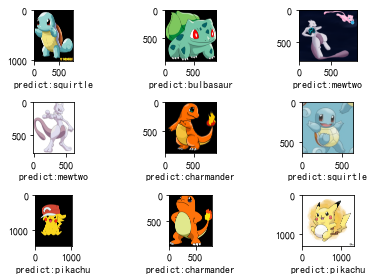

In [ ]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(tf.keras.preprocessing.image.load_img(pre_images[i]))
    plt.xlabel("predict:" + str(pre_label[i]))
plt.tight_layout()  